```
[pre-works]
```
comparison with various version of minGRU
to check my code

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## Hyperparameters and Configuration

In [ ]:
# Modified hyperparameters
SEQUENCE_LENGTH = 128

EMBEDDING_DIM = SEQUENCE_LENGTH
HIDDEN_DIM = EMBEDDING_DIM

BATCH_SIZE = 512
EPOCHS = 10
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1

NUM_LAYERS = 2
FFN_DIM = SEQUENCE_LENGTH
DROPOUT = 0.1

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:1


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('../data/input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003727
Validation dataset size: 111411


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([512, 128])
Target shape: torch.Size([512, 128])
Sample 1: ------------------------------
Input sequence : Would it not shame thee in so fair a troopTo read a lecture of them? If thou wouldst,There shouldst thou find one heinous arti
Target sequence: ould it not shame thee in so fair a troopTo read a lecture of them? If thou wouldst,There shouldst thou find one heinous artic

Sample 2: ------------------------------
Input sequence : osaline whom thou so lovest,With all the admired beauties of Verona:Go thither; and, with unattainted eye,Compare her face wi
Target sequence: saline whom thou so lovest,With all the admired beauties of Verona:Go thither; and, with unattainted eye,Compare her face wit

Sample 3: ------------------------------
Input sequence : read on me;I'll run away till I am bigger, but then I'll fight.CORIOLANUS:Not of a woman's tenderness to be,Requires nor ch
Target sequence: ead on me;I'll run away till I am bigger, but then I'll fight.CORIOLAN

## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = []
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # Training phase with tqdm updates
        epoch_train_losses, step, vram_usage = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses)
        all_vram_usages.append(vram_usage)
        
        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, Epoch Time: {epoch_time:.2f}s',
              f'Average Vram Usage: {np.mean(vram_usage):.2f}MB')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    # average_vram_usage = np.mean(all_vram_usages)
    return model, train_losses_df, val_losses_df


In [13]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [14]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [15]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [16]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [17]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [18]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])

In [19]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

In [20]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [21]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, fused=True)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

## minGRU V1: Structure Like Llama(Trasnformer)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math # math.log 및 상수 사용을 위함
from tqdm import tqdm # tqdm 임포트 추가

# Lion 옵티마이저 임포트 (설치 필요: pip install lion-pytorch)
# from lion_pytorch import Lion # 주석 처리 - 실제 사용 시 주석 해제

def log_g(x: torch.Tensor) -> torch.Tensor:
    """
    은닉 상태 후보를 로그 공간으로 변환하는 함수.
    x >= 0 이면 log(x + 0.5)
    x < 0 이면 log(sigmoid(x))
    """
    return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))

def parallel_scan_log(log_coeffs: torch.Tensor, log_values: torch.Tensor) -> torch.Tensor:
    """
    로그 공간에서 병렬 스캔 연산을 수행합니다. (클램핑 제거됨)
    Args:
        log_coeffs (torch.Tensor): [B, L, H_internal] 형태의 텐서로, log(alpha_t)를 나타냅니다.
        log_values (torch.Tensor): [B, L+1, H_internal] 형태의 텐서로, [log_h_initial, log(beta_1), ..., log(beta_L)]를 나타냅니다.
    Returns:
        torch.Tensor: [B, L, H_internal] 형태의 텐서로, 지수 함수가 적용된 은닉 상태 (h_1 부터 h_L까지)를 나타냅니다.
    """
    log_proda_coeffs_prefix = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0), value=0.0)
    terms_for_logcumsumexp = log_values - log_proda_coeffs_prefix
    log_sum_exp_terms = torch.logcumsumexp(terms_for_logcumsumexp, dim=1) 
    log_hidden_states = log_proda_coeffs_prefix + log_sum_exp_terms
    output_hidden_states = torch.exp(log_hidden_states[:, 1:, :]) 
    return output_hidden_states

class ParallelLogMinGRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, expansion_factor: float = 1.0, epsilon: float = 1e-7):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.expansion_factor = expansion_factor # GRU 셀 내부의 확장 계수
        # GRU 셀 내부에서 사용될 확장된 차원 (hidden_size는 이 셀의 기본 출력 차원을 의미)
        self.internal_expanded_dim = int(hidden_size * self.expansion_factor)
        self.epsilon = epsilon

        # 입력 input_size를 internal_expanded_dim * 2 (은닉 상태 후보용, 게이트용)로 프로젝션
        self.to_hidden_and_gate = nn.Linear(input_size, self.internal_expanded_dim * 2)
        
        # GRU 셀 내부 확장이 있었다면, 다시 hidden_size로 프로젝션
        if self.expansion_factor != 1.0:
            self.to_out = nn.Linear(self.internal_expanded_dim, hidden_size)
        else:
            self.to_out = nn.Identity()
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'linear' in name or 'to_hidden_and_gate' in name or 'to_out' in name :
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name and param is not None: # bias가 있을 경우에만 초기화
                    nn.init.zeros_(param)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, L, input_size]
        B, L, _ = x.size()
        hidden_and_gate = self.to_hidden_and_gate(x) # [B, L, internal_expanded_dim * 2]
        h_candidate_input_expanded, logits_z_expanded = hidden_and_gate.chunk(2, dim=-1) # 각각 [B, L, internal_expanded_dim]
        
        log_A = F.logsigmoid(-logits_z_expanded)
        log_Z_expanded = F.logsigmoid(logits_z_expanded)
        log_h_candidate_contrib_expanded = log_g(h_candidate_input_expanded)
        log_B = log_Z_expanded + log_h_candidate_contrib_expanded

        log_h0_val = torch.full((B, 1, self.internal_expanded_dim),
                                math.log(self.epsilon),
                                device=x.device, dtype=x.dtype)
        log_vals = torch.cat([log_h0_val, log_B], dim=1) # [B, L+1, internal_expanded_dim]
        h_expanded_scan_out = parallel_scan_log(log_A, log_vals) # [B, L, internal_expanded_dim]
        
        output = self.to_out(h_expanded_scan_out) # [B, L, hidden_size]
        return output

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        variance = x.pow(2).mean(dim=-1, keepdim=True)
        return x * torch.rsqrt(variance + self.eps) * self.gamma

class CausalDepthWiseConv1d(nn.Module):
    def __init__(self, dim: int, kernel_size: int):
        super().__init__()
        self.kernel_size = kernel_size
        self.net = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim), 
            nn.Conv1d(dim, dim, kernel_size=1)                       
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_orig_shape = x.shape
        # x.ndim 대신 len(x.shape) 또는 x.dim() 사용
        if x.dim() == 2: 
            x = x.unsqueeze(0) 
        x_transposed = x.transpose(1, 2) 
        x_padded = F.pad(x_transposed, (self.kernel_size - 1, 0), value=0.)
        x_conv_out = self.net(x_padded)
        x_restored = x_conv_out.transpose(1, 2) 
        # len(x_orig_shape) 사용
        if len(x_orig_shape) == 2 and x_restored.shape[0] == 1:
            x_restored = x_restored.squeeze(0) 
        return x_restored

class SwiGLUFFN(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 4.0, dropout: float = 0.1):
        super().__init__()
        ffn_hidden_dim = int(dim * expansion_factor)
        
        self.w1_w3 = nn.Linear(dim, ffn_hidden_dim * 2, bias=False) 
        self.w2 = nn.Linear(ffn_hidden_dim, dim, bias=False)       
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_proj = self.w1_w3(x)
        x1, x3_gate = x_proj.chunk(2, dim=-1) 
        hidden_states = F.silu(x1) * x3_gate
        hidden_states = self.dropout(hidden_states) 
        return self.w2(hidden_states)

class minGRUv1(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int = 2,
        dropout: float = 0.1, 
        expansion_factor_gru: float = 1.0, 
        epsilon_gru: float = 1e-7,
        rms_norm_eps: float = 1e-8,
        ffn_expansion_factor: float = 1.0 
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.input_projection = nn.Linear(embedding_dim, hidden_dim)
        
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            ffn_layer = SwiGLUFFN(
                dim=hidden_dim, 
                expansion_factor=ffn_expansion_factor, 
                dropout=dropout 
            )

            self.layers.append(nn.ModuleList([
                RMSNorm(hidden_dim, eps=rms_norm_eps),                                                 
                ParallelLogMinGRU(
                    input_size=hidden_dim, 
                    hidden_size=hidden_dim, 
                    expansion_factor=expansion_factor_gru, 
                    epsilon=epsilon_gru
                ),                                                                                     
                RMSNorm(hidden_dim, eps=rms_norm_eps),                                                 
                ffn_layer,                                                                             
                nn.Dropout(dropout) if dropout > 0. else nn.Identity()                                 
            ]))

        self.final_norm = RMSNorm(hidden_dim, eps=rms_norm_eps) 
        self.output_fc1 = nn.Linear(hidden_dim, hidden_dim * 4) 
        self.output_fc2 = nn.Linear(hidden_dim * 4, vocab_size)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, None]:
        h = self.embedding(x)
        h = self.input_projection(h)

        for block_idx, block_modules in enumerate(self.layers):
            norm_gru_input, gru_cell, norm_ff_input, ffn_module, dropout_block_output = block_modules
            
            h_gru_residual_source = h
            h_normed_for_gru = norm_gru_input(h)
            h_gru_out = gru_cell(h_normed_for_gru)
            h = h_gru_residual_source + h_gru_out 

            h_ff_residual_source = h
            h_normed_for_ff = norm_ff_input(h)
            h_ff_out = ffn_module(h_normed_for_ff) 
            h = h_ff_residual_source + h_ff_out 
            
            h = dropout_block_output(h)
        
        h_norm_final = self.final_norm(h)
        h_dropped_final = self.final_dropout(h_norm_final) 
        
        output_expanded = F.gelu(self.output_fc1(h_dropped_final)) 
        logits = self.output_fc2(output_expanded)
        
        return logits

In [23]:
### Model Initialization
mingru = minGRUv1(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*1.38), NUM_LAYERS).to(device)

In [24]:
from torchinfo import summary

summary(mingru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
minGRUv1                                 [512, 128, 65]            --
├─Embedding: 1-1                         [512, 128, 128]           8,320
├─Linear: 1-2                            [512, 128, 176]           22,704
├─ModuleList: 1-3                        --                        --
│    └─ModuleList: 2-1                   --                        --
│    │    └─RMSNorm: 3-1                 [512, 128, 176]           176
│    │    └─ParallelLogMinGRU: 3-2       [512, 128, 176]           62,304
│    │    └─RMSNorm: 3-3                 [512, 128, 176]           176
│    │    └─SwiGLUFFN: 3-4               [512, 128, 176]           92,928
│    │    └─Dropout: 3-5                 [512, 128, 176]           --
│    └─ModuleList: 2-2                   --                        --
│    │    └─RMSNorm: 3-6                 [512, 128, 176]           176
│    │    └─ParallelLogMinGRU: 3-7       [512, 128, 176]           

Epoch 1/10, Train Loss: 1.5952, Val Loss: 1.7164, Epoch Time: 55.87s Average Vram Usage: 33.22MB


Epoch 2/10, Train Loss: 1.4873, Val Loss: 1.6871, Epoch Time: 59.44s Average Vram Usage: 33.22MB


Epoch 3/10, Train Loss: 1.3926, Val Loss: 1.6982, Epoch Time: 71.57s Average Vram Usage: 33.22MB


Epoch 4/10, Train Loss: 1.3685, Val Loss: 1.7024, Epoch Time: 62.64s Average Vram Usage: 33.22MB


Epoch 5/10, Train Loss: 1.3434, Val Loss: 1.7188, Epoch Time: 74.96s Average Vram Usage: 33.22MB


Epoch 6/10, Train Loss: 1.3187, Val Loss: 1.7173, Epoch Time: 73.40s Average Vram Usage: 33.22MB


Epoch 7/10, Train Loss: 1.3078, Val Loss: 1.7204, Epoch Time: 77.24s Average Vram Usage: 33.22MB


Epoch 8/10, Train Loss: 1.2931, Val Loss: 1.7199, Epoch Time: 72.17s Average Vram Usage: 33.22MB


Epoch 9/10, Train Loss: 1.2767, Val Loss: 1.6943, Epoch Time: 65.96s Average Vram Usage: 33.22MB


Epoch 10/10, Train Loss: 1.2624, Val Loss: 1.6780, Epoch Time: 77.87s Average Vram Usage: 33.22MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And yo]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you
If I have had never us see thy wife,
Which now, by my itness it gaddy makes;
Put my father with these war. Hast I lady, I pake injury
by Seuciously, and mofft more son: but I conclusive
Thy misrop.

Provost:
How! how farewell;
She will no title, trial of the son God's awhile
And, then is more by a bones, Henry,
And my soul. The hard-wenches expeal'd mine;
Added, the seas? that she is, pity to see yield him;
Since thou wilt not go by.

RICHARD:
Though up a thousand descient her nose bless;
And 


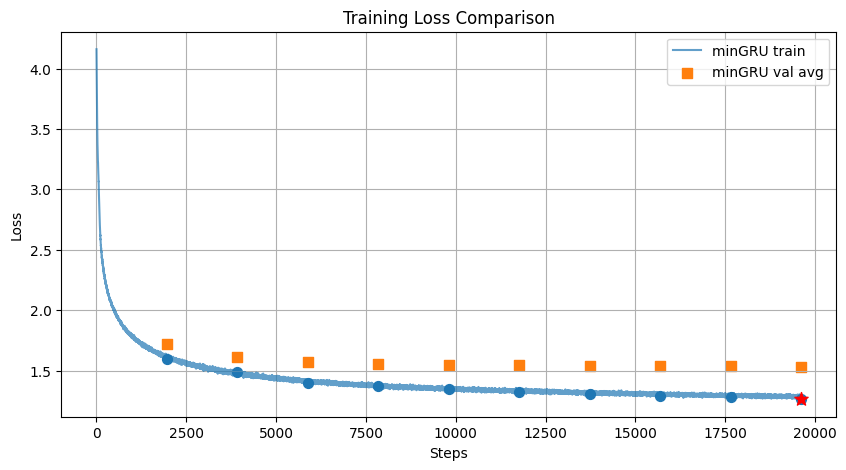

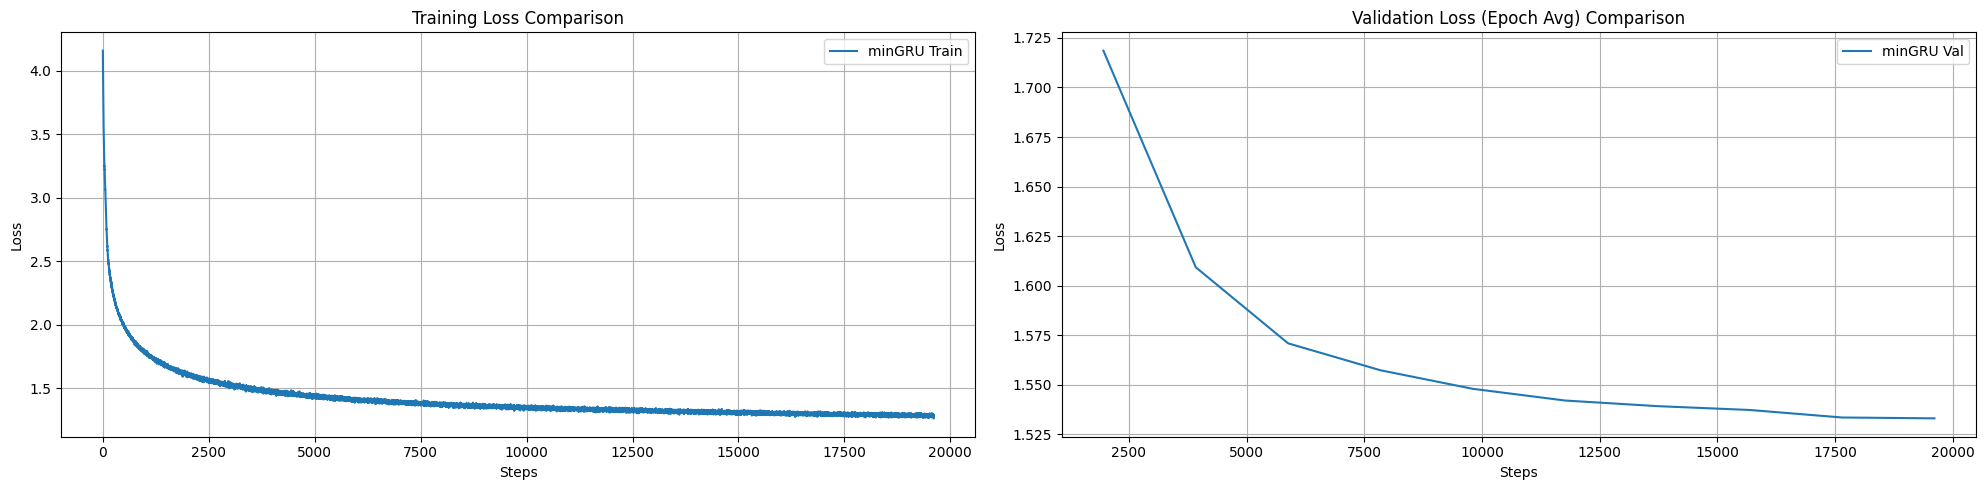

In [25]:
train_and_test("minGRU", mingru, start_text)

## minGRU V2: Structure Like Mamba

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from einops import rearrange

# Helper functions and ParallelLogMinGRU class from minGRU
def log_g(x: torch.Tensor) -> torch.Tensor:
    """
    Transforms the hidden state candidate to log space.
    If x >= 0, log(x + 0.5)
    If x < 0, log(sigmoid(x))
    """
    return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))

def parallel_scan_log(log_coeffs: torch.Tensor, log_values: torch.Tensor) -> torch.Tensor:
    """
    Performs parallel scan operation in log space.
    Args:
        log_coeffs (torch.Tensor): Tensor of shape [B, L, H_internal], representing log(alpha_t).
        log_values (torch.Tensor): Tensor of shape [B, L+1, H_internal], representing [log_h_initial, log(beta_1), ..., log(beta_L)].
    Returns:
        torch.Tensor: Tensor of shape [B, L, H_internal], representing hidden states (h_1 to h_L) with exp applied.
    """
    log_proda_coeffs_prefix = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0), value=0.0)
    terms_for_logcumsumexp = log_values - log_proda_coeffs_prefix
    log_sum_exp_terms = torch.logcumsumexp(terms_for_logcumsumexp, dim=1) 
    log_hidden_states = log_proda_coeffs_prefix + log_sum_exp_terms
    output_hidden_states = torch.exp(log_hidden_states[:, 1:, :]) 
    return output_hidden_states

class ParallelLogMinGRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, expansion_factor: float = 1.0, epsilon: float = 1e-7, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.expansion_factor = expansion_factor
        self.internal_expanded_dim = int(hidden_size * self.expansion_factor)
        self.epsilon = epsilon

        self.to_hidden_and_gate = nn.Linear(input_size, self.internal_expanded_dim * 2, **factory_kwargs)
        
        if self.expansion_factor != 1.0:
            self.to_out = nn.Linear(self.internal_expanded_dim, hidden_size, **factory_kwargs)
        else:
            self.to_out = nn.Identity()
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'to_hidden_and_gate' in name or 'to_out' in name :
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name and param is not None:
                    nn.init.zeros_(param)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, _ = x.size()
        hidden_and_gate = self.to_hidden_and_gate(x)
        h_candidate_input_expanded, logits_z_expanded = hidden_and_gate.chunk(2, dim=-1)
        
        log_A = F.logsigmoid(-logits_z_expanded)
        log_Z_expanded = F.logsigmoid(logits_z_expanded)
        log_h_candidate_contrib_expanded = log_g(h_candidate_input_expanded)
        log_B = log_Z_expanded + log_h_candidate_contrib_expanded

        log_h0_val = torch.full((B, 1, self.internal_expanded_dim),
                                math.log(self.epsilon),
                                device=x.device, dtype=x.dtype)
        
        log_vals = torch.cat([log_h0_val, log_B], dim=1)
        h_expanded_scan_out = parallel_scan_log(log_A, log_vals)
        output = self.to_out(h_expanded_scan_out)
        return output

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim, **factory_kwargs))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x: torch.Tensor):
        norm = self._norm(x.to(torch.float32))
        return (self.weight * norm).to(x.dtype)


class Block(nn.Module):
    def __init__(self, d_model, 
                 d_conv=4, expand=2, 
                 dropout_prob=0.1, 
                 mingru_expansion_factor=1.0, 
                 mingru_epsilon=1e-7, 
                 rms_norm_eps: float = 1e-8, 
                 device=None, dtype=None): 
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Block, self).__init__()
        self.d_model = d_model
        self.d_inner = int(expand * d_model) 
        self.d_conv = d_conv
        
        self.in_proj = nn.Linear(d_model, 2 * self.d_inner, bias=False, **factory_kwargs)

        self.conv1d = nn.Conv1d(
            in_channels=self.d_inner,
            out_channels=self.d_inner,
            bias=True,
            kernel_size=d_conv,
            groups=self.d_inner, 
            padding=d_conv - 1, 
            **factory_kwargs,
        )

        self.ssm = ParallelLogMinGRU(
            input_size=self.d_inner, 
            hidden_size=self.d_inner, 
            expansion_factor=mingru_expansion_factor, 
            epsilon=mingru_epsilon, 
            **factory_kwargs
        )

        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False, **factory_kwargs)
        self.norm = RMSNorm(d_model, eps=rms_norm_eps, **factory_kwargs) 
        self.dropout_res = nn.Dropout(dropout_prob)

    def forward(self, x):
        B, L, D = x.shape
        residual = x
        x_norm = self.norm(x)
        xz = self.in_proj(x_norm) 
        x_in, z = xz.chunk(2, dim=-1) 

        x_conv = rearrange(x_in, 'b l d -> b d l') 
        x_conv = self.conv1d(x_conv)[:, :, :L] 
        x_conv = rearrange(x_conv, 'b d l -> b l d') 
        x_conv_act = F.silu(x_conv) 

        y_ssm = self.ssm(x_conv_act) 
        y_gated = y_ssm * F.silu(z) 
        output = self.out_proj(y_gated) 
        output = residual + self.dropout_res(output) 
        return output

class minGRUv2(nn.Module): 
    def __init__(self, 
                 vocab_size: int, 
                 embedding_dim: int, 
                 hidden_dim: int,    
                 num_layers: int = 2,    
                 dropout: float = 0.1, 
                 expansion_factor_gru: float = 1.0, 
                 epsilon_gru: float = 1e-7,         
                 rms_norm_eps: float = 1e-8,        
                 ffn_expansion_factor: float = 2.0, 
                 d_conv: int = 4,                   
                 device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(minGRUv2, self).__init__()
        
        self.embedding_dim = embedding_dim 
        self.hidden_dim = hidden_dim       
        self.vocab_size = vocab_size # Store vocab_size

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, **factory_kwargs)
        self.dropout_emb = nn.Dropout(dropout)
        
        if self.embedding_dim != self.hidden_dim:
            self.input_proj = nn.Linear(self.embedding_dim, self.hidden_dim, bias=False, **factory_kwargs)
        else:
            self.input_proj = nn.Identity()

        self.layers = nn.ModuleList([
            Block(
                d_model=self.hidden_dim, 
                d_conv=d_conv,
                expand=ffn_expansion_factor, 
                dropout_prob=dropout,
                mingru_expansion_factor=expansion_factor_gru,
                mingru_epsilon=epsilon_gru,
                rms_norm_eps=rms_norm_eps, 
                **factory_kwargs
            )
            for _ in range(num_layers)
        ])
        self.norm_f = RMSNorm(self.hidden_dim, eps=rms_norm_eps, **factory_kwargs) 
        
        if self.hidden_dim != self.embedding_dim:
            self.to_embedding_dim_proj = nn.Linear(self.hidden_dim, self.embedding_dim, bias=False, **factory_kwargs)
        else:
            self.to_embedding_dim_proj = nn.Identity()
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            if module.bias is not None:
                nn.init.zeros_(module.bias)
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, std=0.02)
        elif isinstance(module, nn.Conv1d):
            nn.init.kaiming_normal_(module.weight, nonlinearity='leaky_relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, RMSNorm):
            nn.init.ones_(module.weight)

    def forward(self, input_ids): 
        x = self.embedding(input_ids) 
        x = self.dropout_emb(x)
        
        x = self.input_proj(x) # Projects to hidden_dim
        
        for layer in self.layers:
            x = layer(x)

        x = self.norm_f(x) # Output is hidden_dim
        
        # --- MODIFIED: Project to embedding_dim before using embedding weights for LM head ---
        x_for_lm_head = self.to_embedding_dim_proj(x) # Projects to embedding_dim
        
        # Perform linear transformation using embedding weights (achieves weight tying)
        # Bias is False by convention for tied LM heads, matching original Mamba's lm_head bias=False
        logits = F.linear(x_for_lm_head, self.embedding.weight) 
        # --- END MODIFICATION ---
        
        return logits

In [27]:
### Model Initialization
mingru2 = minGRUv2(vocab_size, EMBEDDING_DIM, HIDDEN_DIM+1, NUM_LAYERS).to(device)

In [28]:
from torchinfo import summary

summary(mingru2, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
minGRUv2                                 [512, 128, 65]            --
├─Embedding: 1-1                         [512, 128, 128]           8,320
├─Dropout: 1-2                           [512, 128, 128]           --
├─Linear: 1-3                            [512, 128, 129]           16,512
├─ModuleList: 1-4                        --                        --
│    └─Block: 2-1                        [512, 128, 129]           --
│    │    └─RMSNorm: 3-1                 [512, 128, 129]           129
│    │    └─Linear: 3-2                  [512, 128, 516]           66,564
│    │    └─Conv1d: 3-3                  [512, 258, 131]           1,290
│    │    └─ParallelLogMinGRU: 3-4       [512, 128, 258]           133,644
│    │    └─Linear: 3-5                  [512, 128, 129]           33,282
│    │    └─Dropout: 3-6                 [512, 128, 129]           --
│    └─Block: 2-2                        [512, 128, 129]     

Epoch 1/10, Train Loss: 1.4629, Val Loss: 1.7452, Epoch Time: 81.34s Average Vram Usage: 37.13MB


Epoch 2/10, Train Loss: 1.3208, Val Loss: 1.6904, Epoch Time: 86.30s Average Vram Usage: 37.13MB


Epoch 3/10, Train Loss: 1.2607, Val Loss: 1.6784, Epoch Time: 125.21s Average Vram Usage: 37.13MB


Epoch 4/10, Train Loss: 1.2485, Val Loss: 1.6708, Epoch Time: 131.53s Average Vram Usage: 37.13MB


Epoch 5/10, Train Loss: 1.1948, Val Loss: 1.6622, Epoch Time: 131.00s Average Vram Usage: 37.13MB


Epoch 6/10, Train Loss: 1.1923, Val Loss: 1.6702, Epoch Time: 123.74s Average Vram Usage: 37.13MB


Epoch 7/10, Train Loss: 1.1846, Val Loss: 1.6779, Epoch Time: 71.45s Average Vram Usage: 37.13MB


Epoch 8/10, Train Loss: 1.1663, Val Loss: 1.7089, Epoch Time: 90.88s Average Vram Usage: 37.13MB


Epoch 9/10, Train Loss: 1.1395, Val Loss: 1.7072, Epoch Time: 99.34s Average Vram Usage: 37.13MB


Epoch 10/10, Train Loss: 1.1326, Val Loss: 1.7517, Epoch Time: 74.29s Average Vram Usage: 37.13MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And yo]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, sir! Well, when I beside, sir; he shall
have time disordering and your trade,--

FRIAR LAURENCE:
No, I, did sleep and feary greatny since blows,
Whom are after, the treasure of a respectable;
And thou, begins to your way, I am beheaded;
And I am cold I can less tale doth thee
And best of justice entertainment chamber:
They chance to Mantua: to the very wives,
For satisfy his honourable humble longer.

CLARENCE:
I think the hand goes to use of thy son;
And thou makest your captive order you to


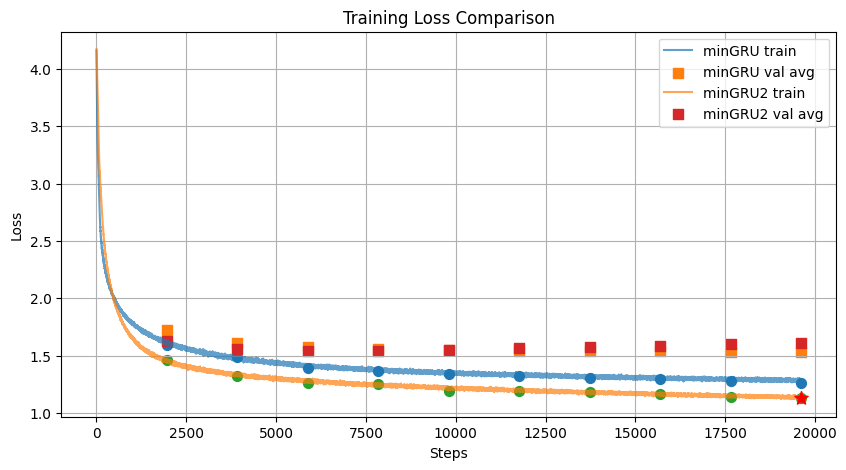

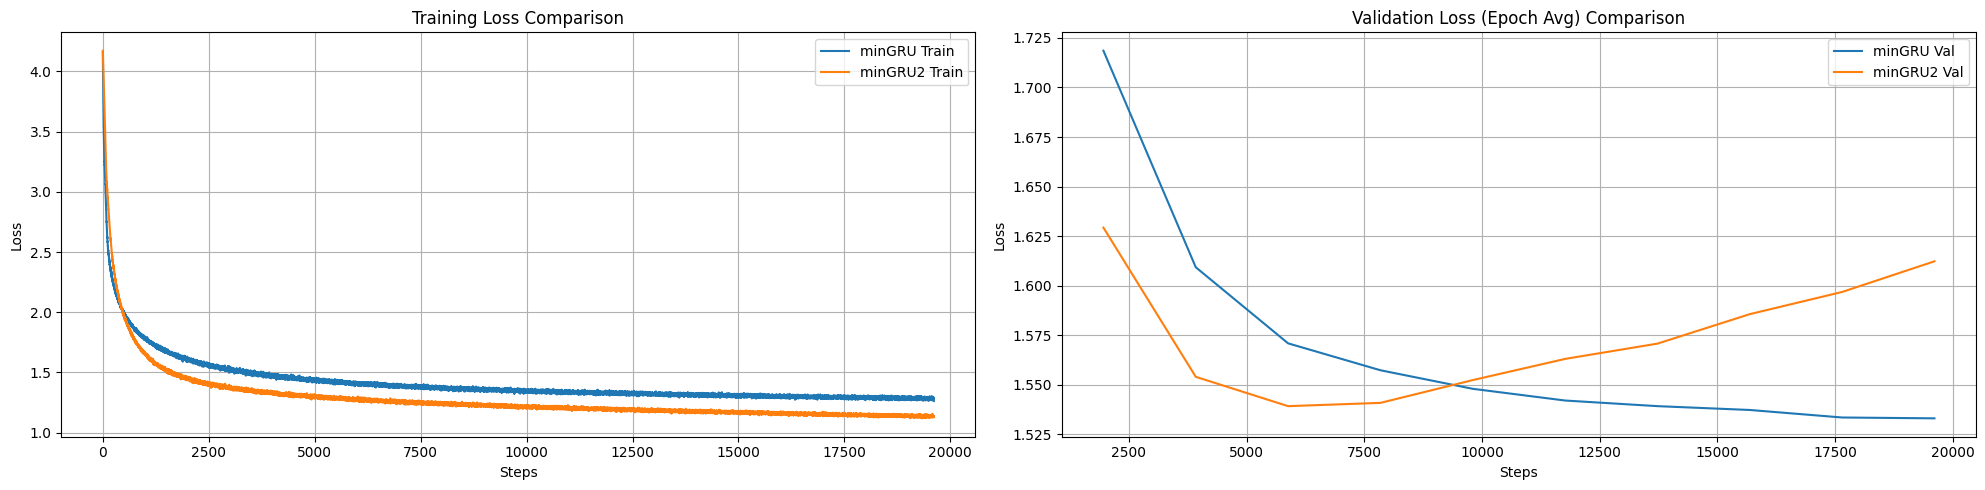

In [29]:
train_and_test("minGRU2", mingru2, start_text)

## minGRU V3: Hybrid Structure

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Optional, Union
from torch.nn import RMSNorm # 사용자의 환경에 RMSNorm이 torch.nn에 있다고 가정합니다.

class CausalDepthWiseConv1d(nn.Module):
    """
    인과적(Causal) 1D 깊이별 분리형 컨볼루션(Depth-wise Separable Convolution) 모듈.
    깊이별 컨볼루션과 점별 컨볼루션을 순차적으로 적용합니다.
    인과성을 유지하기 위해 시퀀스의 왼쪽에 패딩을 추가하여,
    시간 t의 출력은 시간 t까지의 입력에만 의존하도록 합니다.
    """
    def __init__(self, dimension: int, kernel_size: int):
        """
        Args:
            dimension (int): 입력 및 출력 채널의 수.
            kernel_size (int): 컨볼루션 커널의 크기.
        """
        super().__init__()
        self.kernel_size = kernel_size
        # 인과적 패딩 계산: (커널 크기 - 1) 만큼 왼쪽에, 0만큼 오른쪽에 패딩.
        self.causal_padding = (self.kernel_size - 1, 0)

        self.depthwise_pointwise_conv = nn.Sequential(
            # 깊이별 컨볼루션: 각 입력 채널에 대해 독립적인 필터를 적용.
            nn.Conv1d(dimension, dimension, kernel_size=kernel_size, groups=dimension),
            # 점별 컨볼루션: 채널 정보를 혼합하기 위한 1x1 컨볼루션.
            nn.Conv1d(dimension, dimension, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): 입력 텐서. 형태: (배치 크기, 시퀀스 길이, 채널 수).
        Returns:
            torch.Tensor: 출력 텐서. 형태: (배치 크기, 시퀀스 길이, 채널 수).
        """
        # Conv1D를 위해 (배치 크기, 채널 수, 시퀀스 길이) 형태로 변경.
        x_transposed = x.transpose(1, 2)
        # 시퀀스 왼쪽에 인과적 패딩 적용.
        x_padded = F.pad(x_transposed, self.causal_padding)
        # 깊이별-점별 컨볼루션 적용.
        x_conv_out = self.depthwise_pointwise_conv(x_padded)
        # 다시 (배치 크기, 시퀀스 길이, 채널 수) 형태로 변경.
        return x_conv_out.transpose(1, 2)


class MinGRUCoreOps:
    """
    MinGRU의 핵심 수학적 연산을 위한 정적 메소드들을 포함하는 클래스.
    MinGRU의 수학적 공식에 기반한 함수들이며, 사용자 정의 활성화 함수 및
    순환적 업데이트를 위한 병렬 스캔 연산 등을 포함합니다.
    
    """

    @staticmethod
    def g_activation(x: torch.Tensor) -> torch.Tensor:
        """
        MinGRU를 위한 사용자 정의 활성화 함수 'g'.
        g(x) = x + 0.5  (x >= 0 인 경우)
        g(x) = sigmoid(x) (x < 0 인 경우)
        """
        output = torch.empty_like(x)
        positive_mask = x >= 0
        # 양수 또는 0인 경우
        output[positive_mask] = x[positive_mask] + torch.tensor(0.5, dtype=x.dtype, device=x.device)
        # 음수인 경우
        output[~positive_mask] = torch.sigmoid(x[~positive_mask])
        return output

    @staticmethod
    def log_g_activation(x: torch.Tensor) -> torch.Tensor:
        """
        사용자 정의 활성화 함수 'g'의 로그(logarithm) 값.
        log_g(x) = log(x + 0.5) (x >= 0 인 경우)
        log_g(x) = log(sigmoid(x)) = -softplus(-x) (x < 0 인 경우)
        수치적 안정성을 위해 사용됩니다.
        """
        output = torch.empty_like(x)
        positive_mask = x >= 0
        # 양수 또는 0인 경우
        output[positive_mask] = (x[positive_mask] + torch.tensor(0.5, dtype=x.dtype, device=x.device)).log().to(x.dtype)
        # 음수인 경우 (log(sigmoid(x)) = -softplus(-x))
        output[~positive_mask] = (-F.softplus(-x[~positive_mask])).to(x.dtype)
        return output

    @staticmethod
    def _log_space_parallel_scan(log_a_terms: torch.Tensor, log_b_terms: torch.Tensor) -> torch.Tensor:
        """
        로그 공간에서의 병렬 스캔(누적) 연산.
        MinGRU의 순환 관계를 병렬적으로 계산하기 위해 사용됩니다.
        x_t = a_t * x_{t-1} + b_t  형태의 연산을 로그 공간에서 수행합니다.
        (원문: _parallel_scan_log)

        Args:
            log_a_terms (torch.Tensor): 로그 스케일의 'a' 항들. (log(a_t))
            log_b_terms (torch.Tensor): 로그 스케일의 'b' 항들. (log(b_t))
                                      첫 번째 요소는 log(x_0) * a_0 (초기 상태 관련 항)을 포함할 수 있음.
        Returns:
            torch.Tensor: 병렬 스캔 결과의 지수 값 (원래 스케일). (exp(log_x_t))
        """
        # log_a_terms의 누적 합을 계산 (alpha_star). 시퀀스 차원(dim=1)을 따라 누적.
        # 패딩은 초기 조건(x_0)을 처리하기 위함.
        padding_dims = [0] * (log_a_terms.ndim - 2) * 2 + [1, 0] # (..., 1, 0) sequence dimension padding
        alpha_star = F.pad(torch.cumsum(log_a_terms, dim=1), padding_dims)

        # log_b_terms - alpha_star 항에 대해 로그-합-지수(logsumexp) 누적을 수행.
        # 이는 x_0 항과 b_t / (a_1*...*a_t) 항들의 누적 합을 로그 공간에서 계산하는 것과 유사.
        x0_plus_b_star_contribution = torch.logcumsumexp(log_b_terms - alpha_star, dim=1)

        # 최종 로그 스케일 결과: alpha_star + x0_plus_b_star_contribution
        log_x_sequence = alpha_star + x0_plus_b_star_contribution
        return torch.exp(log_x_sequence)

    @staticmethod
    def _mingru_recurrent_update_log_space(log_previous_hidden_state: torch.Tensor,
                                           gate_z: torch.Tensor,
                                           candidate_hidden: torch.Tensor) -> torch.Tensor:
        """
        MinGRU의 순환 업데이트를 로그 공간에서 병렬적으로 수행.
        h_t = (1-z_t)*h_{t-1} + z_t*h_tilde_t
        (원문: _mingru_parallel)

        Args:
            log_previous_hidden_state (torch.Tensor): 이전 은닉 상태의 로그 값 (log(h_{t-1})).
                                                     형태: (배치, 1, 은닉 차원) - 시퀀스의 첫 번째 요소에 해당.
            gate_z (torch.Tensor): 게이트 z_t 값. 형태: (배치, 시퀀스 길이, 은닉 차원).
            candidate_hidden (torch.Tensor): 후보 은닉 상태 h_tilde_t 값. 형태: (배치, 시퀀스 길이, 은닉 차원).

        Returns:
            torch.Tensor: 계산된 은닉 상태 시퀀스 h_t. 형태: (배치, 시퀀스 길이, 은닉 차원).
        """
        # log(z_t) = -softplus(-gate_z)  (log(sigmoid(gate_z)))
        log_z = -F.softplus(-gate_z)
        # log(1-z_t) = -softplus(gate_z) (log(sigmoid(-gate_z)))
        log_one_minus_z = -F.softplus(gate_z)

        # log(h_tilde_t) 계산
        log_candidate_hidden = MinGRUCoreOps.log_g_activation(candidate_hidden)

        # 병렬 스캔을 위한 log_b 항 구성:
        # 첫 번째 항은 log(h_prev) (실제로는 log(h_0) * (1-z_0)에 대응하는 항으로 변환됨)
        # 나머지 항은 log(z_t) + log(h_tilde_t)
        # log_previous_hidden_state는 (B, 1, H) 이므로, dim=1로 concat
        log_b_for_scan = torch.cat((log_previous_hidden_state, log_z + log_candidate_hidden), dim=1)

        # log_a 항은 log(1-z_t)
        # 병렬 스캔 실행
        # h_sequence_plus_initial 결과는 h_0, h_1, ..., h_T-1 을 포함
        h_sequence_plus_initial = MinGRUCoreOps._log_space_parallel_scan(log_one_minus_z, log_b_for_scan)

        # 초기 상태 h_0를 제외한 h_1, ..., h_T-1 시퀀스 반환
        return h_sequence_plus_initial[:, 1:]

    @staticmethod
    def calculate_output_sequence(gate_z: torch.Tensor,
                                  candidate_hidden: torch.Tensor,
                                  initial_hidden_state: torch.Tensor) -> torch.Tensor:
        """
        주어진 게이트, 후보 은닉 상태, 초기 은닉 상태를 사용하여 MinGRU의 출력 시퀀스를 계산.
        (원문: mingru_gate_hidden)

        Args:
            gate_z (torch.Tensor): 게이트 z_t 값.
            candidate_hidden (torch.Tensor): 후보 은닉 상태 h_tilde_t 값.
            initial_hidden_state (torch.Tensor): 초기 은닉 상태 h_0 값.

        Returns:
            torch.Tensor: 계산된 은닉 상태 시퀀스.
        """
        # 수치적 안정성을 위해 작은 epsilon 값을 더한 후 로그 변환.
        epsilon = torch.tensor(1e-12, dtype=initial_hidden_state.dtype, device=initial_hidden_state.device)
        log_initial_hidden_state = (initial_hidden_state + epsilon).log()

        return MinGRUCoreOps._mingru_recurrent_update_log_space(log_initial_hidden_state, gate_z, candidate_hidden)


class MinGRU(nn.Module):
    """
    MinGRU (Minimal Gated Recurrent Unit) 모델.
    여러 MinGRU 레이어를 쌓아 구성할 수 있습니다.
    """
    # 타입 힌트 (JIT 호환성을 위해 Final 제거)
    layer_dims: Tuple[int, ...]
    num_internal_layers: int

    def __init__(
        self,
        input_dim: int,
        hidden_dims_list: List[int],
        use_bias: bool = True,
        apply_layer_norm: bool = True,
        dropout_probability: float = 0.1,
        use_residual: bool = True,
    ):
        """
        Args:
            input_dim (int): 입력 특징의 차원.
            hidden_dims_list (List[int]): 각 MinGRU 레이어의 은닉 차원 리스트.
            use_bias (bool): 선형 계층에서 편향을 사용할지 여부.
            apply_layer_norm (bool): 각 레이어 내부에 LayerNorm을 적용할지 여부.
            dropout_probability (float): 드롭아웃 확률. 0이면 드롭아웃을 적용하지 않음.
            use_residual (bool): 잔차 연결(residual connection)을 사용할지 여부.
        """
        super().__init__()
        self.layer_dims = tuple([input_dim] + hidden_dims_list) # 입력 차원 + 각 레이어 은닉 차원
        self.num_internal_layers = len(hidden_dims_list) # MinGRU 레이어의 수
        self.dropout_probability = dropout_probability
        self.use_residual = use_residual
        self.apply_internal_norm = apply_layer_norm

        torch_layers_list = [] # nn.ModuleList로 관리될 레이어 모듈들
        # 각 레이어의 입력 차원과 출력 차원을 순회
        layer_dim_pairs = zip(self.layer_dims[:-1], self.layer_dims[1:])

        for layer_idx, (current_input_dim, current_output_dim) in enumerate(layer_dim_pairs):
            layer_modules_dict = {} # nn.ModuleDict로 관리될 특정 레이어의 모듈들

            if self.apply_internal_norm:
                layer_modules_dict["norm"] = torch.nn.LayerNorm(current_input_dim)
            else:
                layer_modules_dict["norm"] = torch.nn.Identity()

            # 게이트(z_t)와 후보 은닉 상태(h_tilde_t)를 계산하기 위한 선형 계층
            layer_modules_dict["gate_and_candidate_proj"] = torch.nn.Linear(current_input_dim, current_output_dim * 2, bias=use_bias)

            # 잔차 연결을 위한 차원 정렬용 선형 계층 (입력과 출력 차원이 다를 경우)
            if use_residual and current_input_dim != current_output_dim:
                layer_modules_dict["residual_align_proj"] = torch.nn.Linear(current_input_dim, current_output_dim, bias=False)
            else:
                layer_modules_dict["residual_align_proj"] = torch.nn.Identity()

            # 드롭아웃 (마지막 레이어 제외)
            if self.dropout_probability > 0.0 and layer_idx < (self.num_internal_layers - 1):
                layer_modules_dict["dropout"] = torch.nn.Dropout(p=self.dropout_probability)
            else:
                layer_modules_dict["dropout"] = torch.nn.Identity()

            torch_layers_list.append(torch.nn.ModuleDict(layer_modules_dict))

        self.layers = torch.nn.ModuleList(torch_layers_list)
        self.apply(self._init_weights)  # 가중치 초기화
        
    def _init_weights(self, module: nn.Module):
        # 선형 레이어 가중치 초기화 (게이트 편향 특수 처리 포함)
        for i in range(self.num_internal_layers):
            layer_components = self.layers[i]
            output_dim = self.layer_dims[i+1]
            # 1. 잔차 연결 프로젝션 레이어 초기화 (일반)
            if isinstance(layer_components["residual_align_proj"], nn.Linear):
                nn.init.normal_(layer_components["residual_align_proj"].weight, mean=0.0, std=0.02)
            
            # 2. 게이트 및 후보 은닉 상태 프로젝션 레이어 특별 초기화
            gate_hidden_proj_layer = layer_components["gate_and_candidate_proj"]
            
            # 가중치는 표준 정규분포로 초기화
            nn.init.normal_(gate_hidden_proj_layer.weight, mean=0.0, std=0.02)

            # 편향(bias)은 특별하게 초기화
            if gate_hidden_proj_layer.bias is not None:
                # 편향 텐서는 (output_dim * 2) 크기
                # 앞 절반은 게이트 로짓(gate_logits)용, 뒤 절반은 후보 은닉 상태(candidate_hidden_inputs)용
                
                # 게이트 로짓의 편향을 음수 값으로 초기화 (예: -1.0)
                # sigmoid(음수)는 0에 가까워져, z_t가 작아짐
                # h_t = (1-z_t)*h_{t-1} + z_t*h_tilde_t 에서 (1-z_t)가 커지므로
                # 학습 초기에 이전 은닉 상태 h_{t-1}를 더 많이 유지하도록 유도하여 안정적인 학습에 도움을 줍니다.
                nn.init.constant_(gate_hidden_proj_layer.bias[:output_dim], -1.0)
                
                # 후보 은닉 상태의 편향은 0으로 초기화
                nn.init.zeros_(gate_hidden_proj_layer.bias[output_dim:])
            

    def init_hidden_states(self, input_tensor: torch.Tensor) -> List[torch.Tensor]:
        """
        각 MinGRU 레이어의 초기 은닉 상태를 생성합니다.
        MinGRU의 g 활성화 함수를 사용하여 0으로 초기화된 텐서를 변환합니다.

        Args:
            input_tensor (torch.Tensor): 입력 텐서. 배치 크기, 자료형, 장치 정보를 얻기 위해 사용.
                                         형태: (배치 크기, 시퀀스 길이, 입력 차원).
        Returns:
            List[torch.Tensor]: 각 레이어의 초기 은닉 상태 리스트.
                                각 텐서의 형태: (배치 크기, 1, 해당 레이어의 은닉 차원).
        """
        batch_size = input_tensor.shape[0]
        initial_states = []
        for hidden_dim in self.layer_dims[1:]: # 각 레이어의 출력(은닉) 차원에 대해
            # (배치 크기, 1, 은닉 차원) 형태의 0 텐서 생성 후 g_activation 적용
            zeros = input_tensor.new_zeros(batch_size, 1, hidden_dim, dtype=input_tensor.dtype)
            initial_states.append(MinGRUCoreOps.g_activation(zeros))
        return initial_states

    def forward(
        self,
        input_sequence: torch.Tensor,
        initial_hidden_states_list: Optional[List[torch.Tensor]] = None,
    ) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        """
        MinGRU 모델의 순방향 전파를 수행합니다.

        Args:
            input_sequence (torch.Tensor): 입력 시퀀스. 형태: (배치 크기, 시퀀스 길이, 입력 차원).
            initial_hidden_states_list (Optional[List[torch.Tensor]]):
                제공될 경우 사용할 초기 은닉 상태 리스트.
                None이면 내부적으로 init_hidden_states를 호출하여 생성.

        Returns:
            Tuple[torch.Tensor, List[torch.Tensor]]:
                - 최종 레이어의 출력 시퀀스. 형태: (배치 크기, 시퀀스 길이, 마지막 레이어의 은닉 차원).
                - 각 레이어의 다음 시퀀스를 위한 마지막 은닉 상태 리스트.
                  각 텐서의 형태: (배치 크기, 1, 해당 레이어의 은닉 차원).
        """
        if initial_hidden_states_list is None:
            hidden_states_for_layers = self.init_hidden_states(input_sequence)
        else:
            hidden_states_for_layers = initial_hidden_states_list

        current_layer_input_sequence = input_sequence
        next_step_hidden_states_list: List[torch.Tensor] = []

        for layer_idx in range(self.num_internal_layers):
            layer_module_components = self.layers[layer_idx]

            normalized_sequence = layer_module_components["norm"](current_layer_input_sequence)
            # 게이트와 후보 은닉 상태를 한 번에 계산 후 분리
            gate_values, candidate_hidden_states = layer_module_components["gate_and_candidate_proj"](normalized_sequence).chunk(2, dim=2)

            # 현재 레이어의 초기(또는 이전 스텝의) 은닉 상태
            previous_hidden_state_for_this_layer: torch.Tensor = hidden_states_for_layers[layer_idx]

            # MinGRU 순환 연산
            output_sequence_current_layer = MinGRUCoreOps.calculate_output_sequence(
                gate_values, candidate_hidden_states, previous_hidden_state_for_this_layer
            )
            # 다음 스텝(또는 다음 시퀀스)을 위한 마지막 은닉 상태 저장
            next_step_hidden_states_list.append(output_sequence_current_layer[:, -1:])

            if self.use_residual:
                residual_input = layer_module_components["residual_align_proj"](current_layer_input_sequence)
                output_sequence_current_layer = output_sequence_current_layer + residual_input

            current_layer_input_sequence = layer_module_components["dropout"](output_sequence_current_layer)

        return current_layer_input_sequence, next_step_hidden_states_list


class SwiGLUFFN(nn.Module):
    """
    SwiGLU 활성화 함수를 사용하는 FFN (FeedForward Network) 모듈.
    일반적으로 트랜스포머 모델에서 사용됩니다.
    """
    def __init__(self, dimension: int, expansion_factor: float = 2.0, dropout: float = 0.1):
        """
        Args:
            dimension (int): 입력 및 출력 차원.
            expansion_factor (float): 내부 은닉 차원을 결정하기 위한 확장 비율.
                                      실제 은닉 차원은 dimension * expansion_factor * (2/3) 근사.
            dropout (float): 드롭아웃 확률.
        """
        super().__init__()
        # 내부 은닉 차원 계산 (일반적으로 2/3는 GLU 계열에서 사용됨)
        # 또한, 보통 하드웨어 가속을 위해 8의 배수로 맞춤.
        hidden_dimension = int(dimension * expansion_factor * (2/3))
        hidden_dimension = (hidden_dimension + 7) // 8 * 8 # 8의 배수로 올림

        self.gate_proj = nn.Linear(dimension, hidden_dimension, bias=False) # W_gate
        self.up_proj = nn.Linear(dimension, hidden_dimension, bias=False)   # W_up
        self.down_proj = nn.Linear(hidden_dimension, dimension, bias=False) # W_down
        self.dropout_layer = nn.Dropout(dropout)
        self.activation_fn = nn.SiLU() # Swish 또는 Sigmoid Linear Unit

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        SwiGLU FFN의 순방향 전파.
        Output = Dropout(W_down(SiLU(W_gate(x)) * W_up(x)))
        """
        gated_x = self.activation_fn(self.gate_proj(x))
        activated_x = gated_x * self.up_proj(x)
        return self.dropout_layer(self.down_proj(activated_x))

class minGRUv3(nn.Module):
    """
    MinGRU를 핵심 순환 블록으로 사용하는 전체 언어 모델 아키텍처 (버전 3).
    임베딩, 선택적 컨볼루션, MinGRU 스택, FFN, 최종 정규화 및 출력 프로젝션을 포함합니다.
    """
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        mingru_hidden_dims_config: Union[int, List[int]], # MinGRU 레이어들의 은닉 차원 설정
        num_mingru_layers: Optional[int] = None, # hidden_dims_config가 int일 경우 레이어 수
        dropout_rate: float = 0.1,
        rms_norm_epsilon: float = 1e-8,
        use_convolution_block: bool = True,
        conv_kernel_size: int = 3,
        ffn_expansion_factor: float = 1.0 # SwiGLUFFN의 확장 비율
    ):
        super().__init__()

        # MinGRU 내부 레이어들의 은닉 차원 리스트 결정
        if isinstance(mingru_hidden_dims_config, int):
            if num_mingru_layers is None or num_mingru_layers < 1:
                raise ValueError("`num_mingru_layers`는 `mingru_hidden_dims_config`가 정수일 때 양의 정수여야 합니다.")
            actual_mingru_hidden_dims = [mingru_hidden_dims_config] * num_mingru_layers
        elif isinstance(mingru_hidden_dims_config, list):
            if not mingru_hidden_dims_config:
                raise ValueError("`mingru_hidden_dims_config` 리스트는 비어있을 수 없습니다.")
            actual_mingru_hidden_dims = mingru_hidden_dims_config
        else:
            raise TypeError("`mingru_hidden_dims_config`는 정수 또는 정수 리스트여야 합니다.")

        # MinGRU 모듈의 입력 및 출력 차원
        first_mingru_layer_dim = actual_mingru_hidden_dims[0]
        last_mingru_layer_dim = actual_mingru_hidden_dims[-1]

        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)

        # 임베딩 차원을 첫 번째 MinGRU 레이어의 입력 차원으로 프로젝션
        if embedding_dim != first_mingru_layer_dim:
            self.embedding_to_mingru_projection = nn.Linear(embedding_dim, first_mingru_layer_dim)
        else:
            self.embedding_to_mingru_projection = nn.Identity()

        # 선택적 인과적 깊이별 컨볼루션 블록
        if use_convolution_block:
            self.causal_conv_block = CausalDepthWiseConv1d(first_mingru_layer_dim, conv_kernel_size)
        else:
            self.causal_conv_block = nn.Identity()

        # MinGRU 전 정규화
        self.norm_before_mingru = RMSNorm(first_mingru_layer_dim, eps=rms_norm_epsilon)

        self.mingru_stack = MinGRU(
            input_dim=first_mingru_layer_dim,
            hidden_dims_list=actual_mingru_hidden_dims,
            apply_layer_norm=True, # MinGRU 내부 LayerNorm 사용
            dropout_probability=dropout_rate,
            use_residual=True      # MinGRU 내부 잔차 연결 사용
        )

        # MinGRU 블록의 입력과 출력 차원이 다를 경우 잔차 연결을 위한 프로젝션
        if first_mingru_layer_dim != last_mingru_layer_dim:
            self.mingru_residual_projection = nn.Linear(first_mingru_layer_dim, last_mingru_layer_dim)
        else:
            self.mingru_residual_projection = nn.Identity()

        # MinGRU 후, FFN 전 정규화
        self.norm_after_mingru_before_ffn = RMSNorm(last_mingru_layer_dim, eps=rms_norm_epsilon)
        self.ffn_block = SwiGLUFFN(
            dimension=last_mingru_layer_dim,
            expansion_factor=ffn_expansion_factor,
            dropout=dropout_rate
        )

        # 최종 정규화 및 로짓 프로젝션
        self.final_output_norm = RMSNorm(last_mingru_layer_dim, eps=rms_norm_epsilon)
        self.to_logits_projection = nn.Linear(last_mingru_layer_dim, vocab_size)
        
        self.apply(self._init_weights)

    def _init_weights(self, module: nn.Module): # module 인자를 명시적으로 타입 힌트
        """
        모델 내 각 모듈의 가중치를 초기화합니다.
        self.apply() 메소드에 의해 호출됩니다.
        """
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02) 
        elif isinstance(module, nn.Conv1d):
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='leaky_relu') # mode='fan_in'이 일반적
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, RMSNorm):
            if hasattr(module, 'weight') and module.weight is not None: # RMSNorm에 weight가 있을 경우
                nn.init.ones_(module.weight)
        elif isinstance(module, nn.LayerNorm): # MinGRU 내부의 LayerNorm 처리
            if hasattr(module, 'weight') and module.weight is not None:
                nn.init.ones_(module.weight)
            if hasattr(module, 'bias') and module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor: # 반환 타입에서 None 제거, 일반적으로 로짓만 반환
        """
        minGRUv3 모델의 순방향 전파.

        Args:
            input_ids (torch.Tensor): 입력 토큰 ID 시퀀스. 형태: (배치 크기, 시퀀스 길이).

        Returns:
            torch.Tensor: 최종 로짓. 형태: (배치 크기, 시퀀스 길이, 어휘 크기).
        """
        # 1. 임베딩 및 초기 프로젝션
        current_hidden_repr = self.token_embedding(input_ids)
        current_hidden_repr = self.embedding_to_mingru_projection(current_hidden_repr)

        # 2. (선택적) 컨볼루션 블록 + 잔차 연결
        residual_conv_input = current_hidden_repr
        if not isinstance(self.causal_conv_block, nn.Identity):
            # 컨볼루션 블록이 Identity가 아닐 때만 연산 (즉, use_convolution_block=True 일 때)
            current_hidden_repr = residual_conv_input + self.causal_conv_block(residual_conv_input)
        # else: current_hidden_repr은 residual_conv_input과 동일하게 유지됨

        # 3. MinGRU 블록 + 잔차 연결
        residual_mingru_input = current_hidden_repr
        mingru_input_normalized = self.norm_before_mingru(residual_mingru_input)
        mingru_output_sequence, _ = self.mingru_stack(mingru_input_normalized) # 다음 은닉 상태는 사용 안함
        current_hidden_repr = self.mingru_residual_projection(residual_mingru_input) + mingru_output_sequence

        # 4. FFN 블록 + 잔차 연결
        residual_ffn_input = current_hidden_repr
        ffn_input_normalized = self.norm_after_mingru_before_ffn(residual_ffn_input)
        current_hidden_repr = residual_ffn_input + self.ffn_block(ffn_input_normalized)

        # 5. 최종 정규화 및 로짓 계산
        final_representation_normalized = self.final_output_norm(current_hidden_repr)
        logits = self.to_logits_projection(final_representation_normalized)

        return logits

In [31]:
### Model Initialization
mingru3 = minGRUv3(vocab_size, EMBEDDING_DIM, HIDDEN_DIM*2, NUM_LAYERS).to(device)

In [32]:
from torchinfo import summary

summary(mingru3, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
minGRUv3                                 [512, 128, 65]            --
├─Embedding: 1-1                         [512, 128, 128]           8,320
├─Linear: 1-2                            [512, 128, 256]           33,024
├─CausalDepthWiseConv1d: 1-3             [512, 128, 256]           --
│    └─Sequential: 2-1                   [512, 256, 128]           --
│    │    └─Conv1d: 3-1                  [512, 256, 128]           1,024
│    │    └─Conv1d: 3-2                  [512, 256, 128]           65,792
├─RMSNorm: 1-4                           [512, 128, 256]           256
├─MinGRU: 1-5                            [512, 128, 256]           --
│    └─ModuleList: 2-2                   --                        --
│    │    └─ModuleDict: 3-3              --                        132,096
│    │    └─ModuleDict: 3-4              --                        132,096
├─Identity: 1-6                          [512, 128, 256]    

Epoch 1/10, Train Loss: 1.4829, Val Loss: 1.7242, Epoch Time: 231.10s Average Vram Usage: 41.28MB


Epoch 2/10, Train Loss: 1.4095, Val Loss: 1.6767, Epoch Time: 178.11s Average Vram Usage: 41.23MB


Epoch 3/10, Train Loss: 1.3364, Val Loss: 1.6626, Epoch Time: 162.46s Average Vram Usage: 41.23MB


Epoch 4/10, Train Loss: 1.3257, Val Loss: 1.6485, Epoch Time: 275.21s Average Vram Usage: 41.23MB


Epoch 5/10, Train Loss: 1.3102, Val Loss: 1.6246, Epoch Time: 292.78s Average Vram Usage: 41.23MB


Epoch 6/10, Train Loss: 1.2840, Val Loss: 1.6351, Epoch Time: 238.85s Average Vram Usage: 41.23MB


Epoch 7/10, Train Loss: 1.2546, Val Loss: 1.6183, Epoch Time: 176.20s Average Vram Usage: 41.23MB


Epoch 8/10, Train Loss: 1.2529, Val Loss: 1.6060, Epoch Time: 180.90s Average Vram Usage: 41.23MB


Epoch 9/10, Train Loss: 1.2363, Val Loss: 1.6241, Epoch Time: 141.86s Average Vram Usage: 41.23MB


Epoch 10/10, Train Loss: 1.2307, Val Loss: 1.6315, Epoch Time: 141.55s Average Vram Usage: 41.23MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And yo]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you rely daughter me will not a cereman
Make it not; so trouble him joy face,
All the letters o' the time, madam, he doth see home
What you plots; this is my compeat within to be had
So soon. If the Fortune, they see-hope shall may woo
Which stating by this wars. For this is yourself
waked fox yourself south thy surge,

RATCLIFF:
Sleep in this ill shadow the nobsigned me
And art our chaince.

LADY CAPULET:
O, person, but mine honesty, and to fall of Nurse,
Even seem dull your worship bawd; a lord,


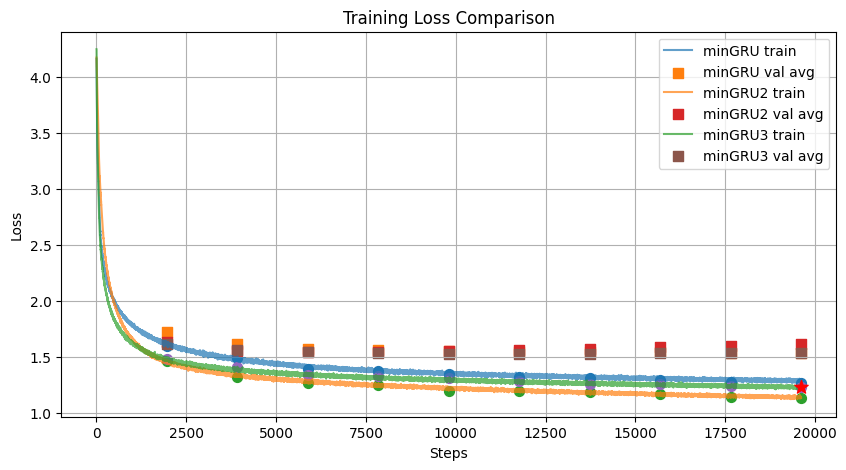

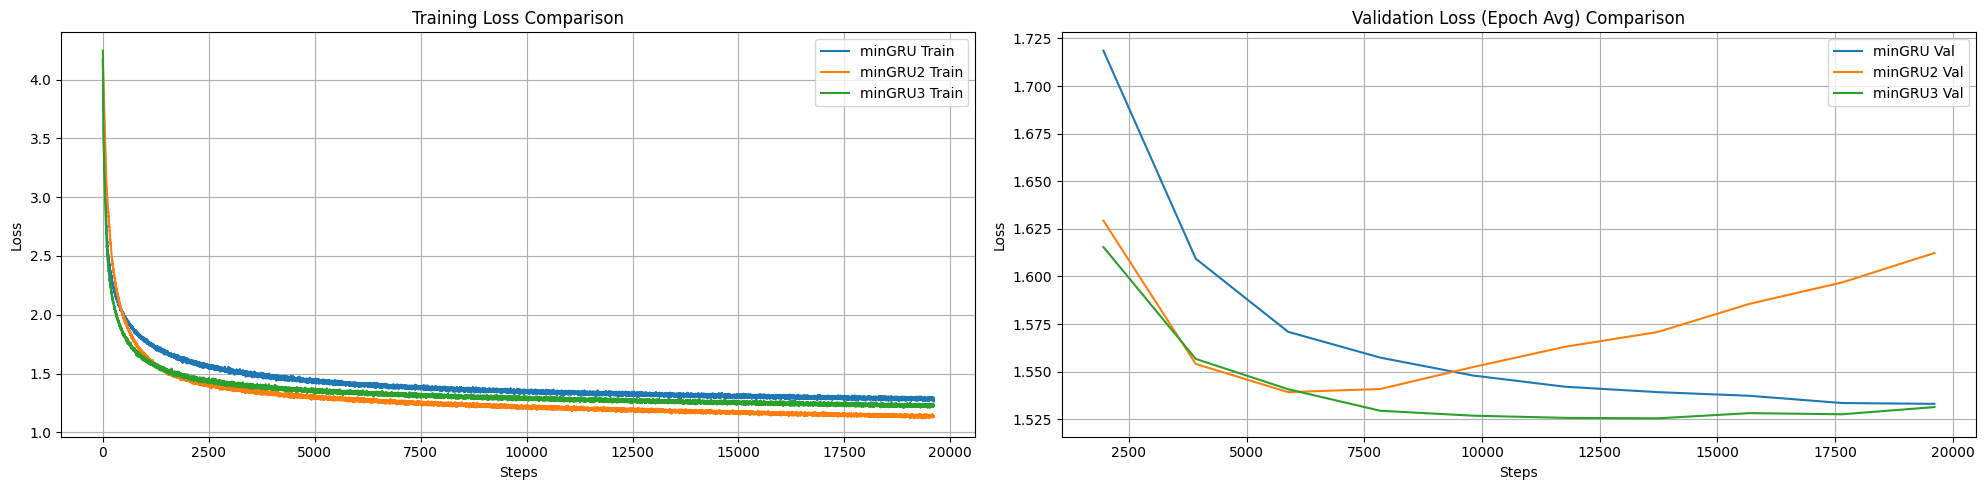

In [33]:
train_and_test("minGRU3", mingru3, start_text)